# Data Preprocessing
## Part 1
### TF-IDF score for blogs
After scrapping a blog website, we could extract key phares/words to rank and classify the kind of information that experts put on blogs. In this stage of the project, we label data manually. How we do that considering that every website has thousand of words? 
* Extract hopeful phrases
Bag of words is one of the most popular useful techniques for handling meaningful features, but in large corporal, is not the appropiate probably. Barg of words works with absolute term frequency, so all words that you don't delete as stopwords and have high frecuency could overshadow other more important terms. TF-IDF model use a normalized factor that we are using in the following develop.

Importing all relevant packages

In [1]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import nltk
import re

Building **expandContractions** function and definition of stop words vector

In [3]:
"""
from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
all credits go to alko and arturomp @ stack overflow.
"""

with open('../Data_Story/wordLists/contractionList.txt', 'r') as f:
    cList = json.loads(f.read())
    c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

Reading data from Data Extraction folder

In [4]:
df = pd.read_csv('../Data_Extraction/reviews_blog_a.csv', usecols=['Name', 'Description'])

In [12]:
wpt = nltk.WordPunctTokenizer()
stemmer = PorterStemmer() 
stop_words = []
with open('../Data_Story/wordLists/stop_wordsList.txt') as f:
    stop_words = f.read().rstrip()

Defining **normalizer** function to expand contractions, remove special characters and split all sentences. We use tokenizer to split sentences in words and delete stop words. Then, words and sentences are joining again. The result is a **corpus normalized**.

In [13]:
def normalizer(paragrahp):
    paragrahp = expandContractions(paragrahp.lower())
    paragrahp_c = paragrahp.split('.')[:-1]
    # lower case and remove special character/whitespace
    paragrahp = [re.sub(r'[^a-zA-Z\s]','', sentence) for sentence in paragrahp_c]
    paragrahp = [sentence.strip() for sentence in paragrahp]
    tokens = [wpt.tokenize(sentence) for sentence in paragrahp]
    tokens_filtered = [[word for word in token if word not in stop_words] for token in tokens]
    paragrahp_norm = [' '.join(tokens) for tokens in tokens_filtered]
    return paragrahp_norm

Defining **key word extractor** function that computes a normalized frequency of terms in pairs. We filter lower scores to build a dataframe with a **vocabulary of phrases and TF-IDF values**.

In [14]:
def key_word_extractor(norm_corpus):
    tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, ngram_range=(2,2), max_features=40)
    tv_matrix = tv.fit_transform(norm_corpus)
    tv_matrix = tv_matrix.toarray()

    idx = [i for i in range(len(norm_corpus))]
    vocab = tv.get_feature_names()
    df_tfidV = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab, index=idx)

    key_values = []
    key_words = []
    for i in range(len(norm_corpus)):
        for column in vocab:
            if df_tfidV[column][i] > 0.20:
                key_values.append(df_tfidV[column][i])
                key_words.append(column)
    return key_words, key_values

Applying the below functions to data:

In [15]:
key_words = [key_word_extractor(normalizer(review))[0] for review in df['Description']]   
key_values = [key_word_extractor(normalizer(review))[1] for review in df['Description']] 

In [16]:
l_words = []
l_values = []
for list_words in key_words:
    l_words = [*l_words, *list_words] 
    
for list_values in key_values:
    l_values = [*l_values, *list_values]

In [17]:
data = {'key_words': l_words, 'key_values': l_values}
df_keys = pd.DataFrame(data)

Now, it's time to examine the result

In [20]:
df_keys.head(20)

,key_words,key_values
0,toast crave,1.00
1,cinnamon sugar,0.41
2,mitigate toast,0.41
3,nutella mitigate,0.41
4,slathered nutella,0.41
5,sugar slathered,0.41
6,toast cravings,0.41
7,best coffee,0.71
8,coffee neighborhood,0.71
9,best parklet,0.26


Finally, we save dataframe as csv file for manual labeled

In [26]:
#df_keys.to_csv('preprocessing/key_words.csv', index=False)

key_words has a round of one thousand of words. We define a **category** and a **section** for each one. Criteria is the following:

1. Only are considered the phrases with a concrete and valid meaning
2. If a phrase classify as meaningful, it belongs to:

a) **Coffee**: all phrases relatives to types of drinks, beans, roasters, baristas, special types of sugar, milk,  and items that involving the experience about the cup of coffee.

b) **Place**: place features as decorationg, description of inside and outside spaces, parklets, sunsets from the seat, music, gardens, streets around; about the service itself (coffee to here, to go, wifi).

c) **Food**: phrases about pastries, donuts, bagels, baked items in general, sandwiches, phrases relatives to breakfast and lunch.

d) **None**: all the rest.

3. Each phrase gets a category and a section:

* Coffee: Baristas, Roasting, Beans, Drinks, Sentiment, None

* Place: Decoration, To here, To go, Outside, Sentiment, Size of the coffee shop, wifi, None

* Food: Sentiment, Breakfast, Baked (tiny items to eat with the coffee), Lunch and Brunch, None

Finally, if you are wondering what kind of words do we find in this dataFrame, check the image below:

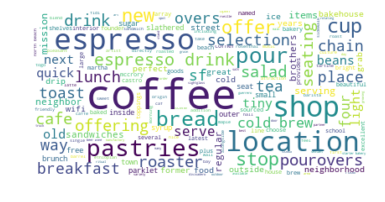

In [52]:
text = ' '.join(df_keys['key_words'])
wordcloud = WordCloud(background_color="white",max_font_size=50).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()